In [1]:
import os
from collections import defaultdict

import pandas as pd
import numpy as np
import torch
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          Trainer, TrainingArguments, get_scheduler, DistilBertModel, DistilBertConfig)

from torch.utils.data import DataLoader
from torch.optim import AdamW

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

/Users/ashutosh/Projects/venv-text/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Data Loading and Preprocessing

In [2]:
root_dir = 'data'
data_dirs = [f'{root_dir}/{filename}' for filename in os.listdir(root_dir)]
data_dirs

['data/20k_abstracts_numbers_with_@',
 'data/20k_abstracts',
 'data/Numbers_replaced_with_@',
 'data/200k_abstracts']

In [3]:
def get_lines(filename):
    """
    Reads the contents of a file and returns a list of lines.
    Parameters:
    filename (str): The path of the file to be read.
    Returns:
    list: A list of lines read from the file.
    """

    with open(filename, 'r') as file:
        lines = file.readlines()
    return lines

In [4]:
train_lines = get_lines(f'{root_dir}/20k_abstracts/train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( 0-100 mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .\n',
 'METHODS\tSerum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF )

In [5]:
def preprocess_text(filename):
    """
    Preprocesses the text from a given file and returns a pandas DataFrame containing the processed data.
    Parameters:
    - filename (str): The path to the file containing the text data.
    Returns:
    - pandas.DataFrame: A DataFrame containing the processed data with the following columns:
        - 'abstract_id': The ID of the abstract.
        - 'line_number': The line number of the text within the abstract.
        - 'target': The target label.
        - 'text': The processed text.
        - 'total_lines': The total number of lines in the abstract.
    """

    lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []

    for line in lines:
        if line.startswith("###"):
            abstract_id = int(line.strip("#").strip())
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()
            for line_num, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                line_data['abstract_id'] = abstract_id
                line_data['line_number'] = line_num
                line_data['target'] = target_text_split[0]
                line_data['text'] = target_text_split[1].lower()
                line_data['total_lines'] = len(abstract_line_split)
                abstract_samples.append(line_data)
        else:
            abstract_lines += line

    return pd.DataFrame(abstract_samples)

In [6]:
train_data = preprocess_text(f'{root_dir}/20k_abstracts/train.txt')
val_data = preprocess_text(f'{root_dir}/20k_abstracts/dev.txt')
test_data = preprocess_text(f'{root_dir}/20k_abstracts/test.txt')
len(train_data), len(val_data), len(test_data)

(180040, 30212, 30135)

In [7]:
train_data.head(15)

,abstract_id,line_number,target,text,total_lines
0,24293578,0,OBJECTIVE,to investigate the efficacy of 6 weeks of dail...,12
1,24293578,1,METHODS,a total of 125 patients with primary knee oa w...,12
2,24293578,2,METHODS,outcome measures included pain reduction and i...,12
3,24293578,3,METHODS,pain was assessed using the visual analog pain...,12
4,24293578,4,METHODS,secondary outcome measures included the wester...,12
5,24293578,5,METHODS,"serum levels of interleukin 1 ( il-1 ) , il-6 ...",12
6,24293578,6,RESULTS,there was a clinically relevant reduction in t...,12
7,24293578,7,RESULTS,the mean difference between treatment arms ( 9...,12
8,24293578,8,RESULTS,"further , there was a clinically relevant redu...",12
9,24293578,9,RESULTS,these differences remained significant at 12 w...,12


In [8]:
# take a sample of data for training locally
train_data = train_data.sample(10000, random_state=42)
test_data = test_data.sample(2000, random_state=42)
val_data = val_data.sample(2000, random_state=42)

target
METHODS        3286
RESULTS        3227
CONCLUSIONS    1509
BACKGROUND     1228
OBJECTIVE       750
Name: count, dtype: int64


<Axes: xlabel='target'>

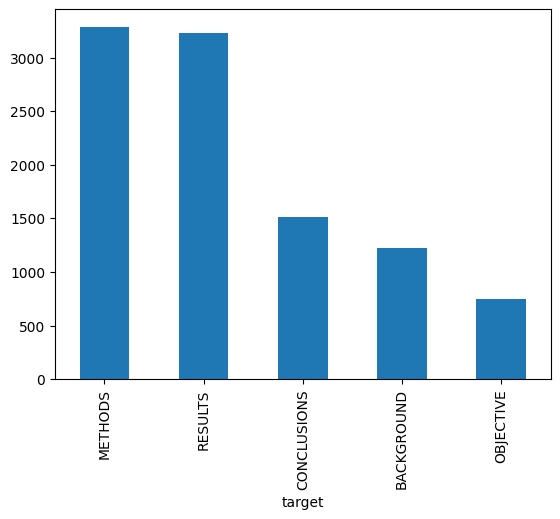

In [9]:
print(train_data['target'].value_counts())
train_data['target'].value_counts().plot(kind='bar')

<Axes: ylabel='Frequency'>

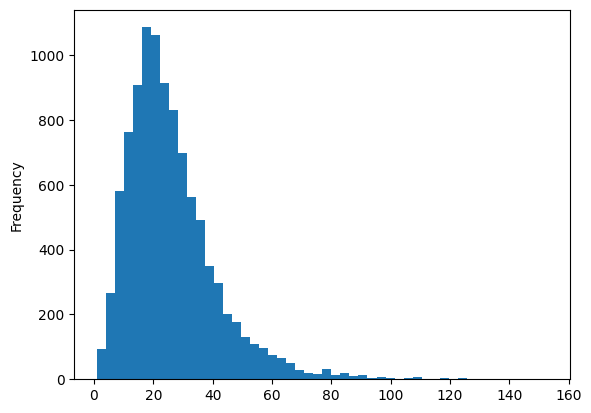

In [10]:
train_data['text'].apply(lambda x: len(x.split())).plot(kind='hist', bins=50)

<Axes: ylabel='Frequency'>

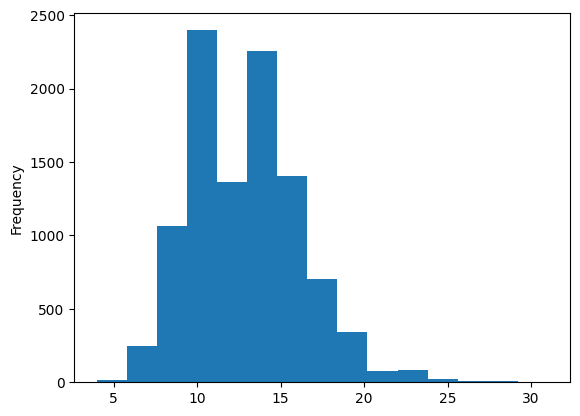

In [11]:
train_data['total_lines'].plot(kind='hist', bins=15)

In [12]:
print(train_data.isnull().sum())
print(val_data.isnull().sum())

abstract_id    0
line_number    0
target         0
text           0
total_lines    0
dtype: int64
abstract_id    0
line_number    0
target         0
text           0
total_lines    0
dtype: int64


In [13]:
target_to_idx = {target: idx for idx, target in enumerate(train_data['target'].unique())}
target_to_idx

{'RESULTS': 0, 'METHODS': 1, 'CONCLUSIONS': 2, 'BACKGROUND': 3, 'OBJECTIVE': 4}

In [14]:
train_data['target'] = train_data['target'].apply(lambda x: target_to_idx[x])
val_data['target'] = val_data['target'].apply(lambda x: target_to_idx[x])
test_data['target'] = test_data['target'].apply(lambda x: target_to_idx[x])

In [15]:
model_ckpt = 'distilbert/distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_ckpt, use_fast=True)

In [16]:
def make_dataset(data_encodings):
    """
    Create a dataset from the given data encodings.
    Parameters:
    - data_encodings (dict): A dictionary containing the data encodings.
    Returns:
    - list: A list of dictionaries, where each dictionary contains the key-value pairs from the data encodings.
    """
    return [{k: v[i] for k, v in data_encodings.items()} for i in range(len(data_encodings.input_ids))]

In [17]:
tokenized_train = tokenizer(train_data['text'].tolist(), padding=True, truncation=True, return_tensors='pt')
tokenized_train['labels'] = torch.tensor(train_data['target'].tolist())
tokenized_train = make_dataset(tokenized_train)

tokenized_val = tokenizer(val_data['text'].tolist(), padding=True, truncation=True, return_tensors='pt')
tokenized_val['labels'] = torch.tensor(val_data['target'].tolist())
tokenized_val = make_dataset(tokenized_val)

tokenized_test = tokenizer(test_data['text'].tolist(), padding=True, truncation=True, return_tensors='pt')
tokenized_test['labels'] = torch.tensor(test_data['target'].tolist())
tokenized_test = make_dataset(tokenized_test)

### Utility Functions

In [18]:
def compute_metrics(preds, labels):
    """
    Compute evaluation metrics for the given predictions.
    Args:
        preds (list): A list containing the model predictions.
        labels (list): A list containing the true labels.
    Returns:
        dict: A dictionary containing the computed evaluation metrics.
            - 'accuracy': The accuracy score.
            - 'f1': The weighted F1 score.
    """
    
    f1 = f1_score(y_true=labels, y_pred=preds, average='weighted')
    acc = accuracy_score(y_true=labels, y_pred=preds)
    return {'accuracy': acc, 'f1': f1}

In [19]:
from typing import Any


class MetricMonitor:
    """
    A class for monitoring and calculating metrics.
    Attributes:
        float_precision (int): The precision of floating point numbers.
    Methods:
        __init__(self, float_precision=4): Initializes the MetricMonitor object.
        reset(self): Resets the metrics.
        update(self, **kargs): Updates the metrics with new values.
        __str__(self): Returns a string representation of the metrics.
        __call__(self, *args: Any, **kwds: Any) -> Any: Returns the metrics as a dictionary.
        getinfo(self): Returns the metrics.
    """

    def __init__(self, float_precision=4):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, **kargs):
        for key, value in kargs.items():
            metric = self.metrics[key]
            
            metric["val"] += value
            metric["count"] += 1
            metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=key, avg=metric["avg"], float_precision=self.float_precision
                )
                for key, metric in self.metrics.items()
            ]
        )
    
    def __call__(self, *args: Any, **kwds: Any) -> Any:
        return {key: metric["avg"] for key, metric in self.metrics.items()}
    
    def getinfo(self):
        return self.metrics

In [20]:
def load_dataloader(data, split='train', batch_size=16):
    """
    Load a PyTorch DataLoader for the given data.
    Parameters:
    - data: The dataset to load into the DataLoader.
    - split: The split of the data to load. Default is 'train'.
    - batch_size: The batch size for the DataLoader. Default is 16.
    Returns:
    - A PyTorch DataLoader object.
    """

    if split == 'train':
        return DataLoader(data, batch_size=batch_size, shuffle=True)
    else:
        return DataLoader(data, batch_size=batch_size)

### Initializing model and its parameters

In [21]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=len(target_to_idx), label2id=target_to_idx, id2label={idx: target for target, idx in target_to_idx.items()})
optimizer = AdamW(model.parameters(), lr=5e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
epochs = 2
batch_size = 16

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
train_dl = load_dataloader(tokenized_train, split='train', batch_size=batch_size)
val_dl = load_dataloader(tokenized_val, split='val', batch_size=batch_size)
# next(iter(train_dl))

In [23]:
num_train_steps = math.ceil(len(train_dl.dataset) / batch_size) * epochs
print(num_train_steps)

lr_scheduler = get_scheduler(
    'linear',
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_train_steps
)
model.to(device)

1250


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

### Training Code with runninng loss calculation

In [24]:
def train_epoch(model, train_dl, optimizer, epoch, device, lr_scheduler=None):
    """
    Train the model for one epoch.
    Parameters:
    - model: The model to train.
    - train_dl: The training DataLoader.
    - optimizer: The optimizer to use for training.
    - epoch: The current epoch number.
    - device: The device to run the training on.
    - lr_scheduler: The learning rate scheduler to use.
    Returns:
    - float: The average loss for the epoch.
    """

    model.train()
    metric_monitor = MetricMonitor()
    stream = tqdm(enumerate(train_dl, start=1), total=len(train_dl))
    for i, batch in stream:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss

        metric_monitor.update(loss=loss.item())

        y_pred = torch.argmax(outputs.logits, dim=-1).to('cpu')
        metrics = compute_metrics(y_pred, batch['labels'].to('cpu'))
        metric_monitor.update(**metrics)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if lr_scheduler is not None:
            lr_scheduler.step()

        stream.set_description(
            (
                f"Epoch: {epoch+1} - Training loss: {metric_monitor.getinfo()['loss']['avg']:.4f}"
            )
        )

    return metric_monitor

In [25]:
def evaluate(model, val_dl, device):
    """
    Evaluate the model on the validation set.
    Parameters:
    - model: The model to evaluate.
    - val_dl: The validation DataLoader.
    - device: The device to run the evaluation on.
    Returns:
    - dict: A dictionary containing the evaluation metrics.
    """

    model.eval()
    metric_monitor = MetricMonitor()
    stream = tqdm(enumerate(val_dl, start=1), total=len(val_dl))
    for i, batch in stream:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss = outputs.loss

        metric_monitor.update(loss=loss.item())
        y_pred = torch.argmax(outputs.logits, dim=-1).to('cpu')
        metrics = compute_metrics(y_pred, batch['labels'].to('cpu'))
        metric_monitor.update(**metrics)

        stream.set_description(
            (
                f"Validation loss: {metric_monitor.getinfo()['loss']['avg']:.4f}"
            )
        )

    return metric_monitor

In [26]:
for epoch in range(epochs):
    train_metrics = train_epoch(model, train_dl, optimizer, epoch, device, lr_scheduler=lr_scheduler)
    val_metrics = evaluate(model, val_dl, device)
    print(f"Epoch: {epoch+1}/{epochs} - Training loss: {train_metrics.getinfo()['loss']['avg']:.4f} - Training F1 Score: {train_metrics.getinfo()['f1']['avg']:.4f}")
    print(f"Epoch: {epoch+1}/{epochs} - Validation loss: {val_metrics.getinfo()['loss']['avg']:.4f} - Validation F1 Score: {val_metrics.getinfo()['f1']['avg']:.4f}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 1/2 - Training loss: 0.5555 - Training F1 Score: 0.7864
Epoch: 1/2 - Validation loss: 0.4251 - Validation F1 Score: 0.8383


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 2/2 - Training loss: 0.3121 - Training F1 Score: 0.8860
Epoch: 2/2 - Validation loss: 0.4002 - Validation F1 Score: 0.8445


### Performance on Test Data

In [27]:
test_metrics = MetricMonitor()
test_dl = load_dataloader(tokenized_test, split='test', batch_size=batch_size)
stream = tqdm(enumerate(test_dl, start=1), total=len(test_dl))
for i, batch in stream:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        output = model(**batch)
    y_pred = torch.argmax(output.logits, dim=-1).to('cpu')
    metrics = compute_metrics(y_pred, batch['labels'].to('cpu'))
    test_metrics.update(**metrics)
    test_metrics.update(loss=output.loss.item())

print(f"Test loss: {test_metrics.getinfo()['loss']['avg']:.4f} - Test F1 Score: {test_metrics.getinfo()['f1']['avg']:.4f}")

  0%|          | 0/125 [00:00<?, ?it/s]

Test loss: 0.4405 - Test F1 Score: 0.8520


In [28]:
out_dir = "models"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

out_file = 'distilbert_abstracts.pth'
out_path = os.path.join(out_dir,out_file)
print((out_path))

models/distilbert_abstracts.pth


In [29]:
model.save_pretrained(out_path)